В этом файле создается модель бинарной классификации - "является ли инструмент, звучащий в файле скрипкой?"

Для начала подготовим данные: разделим каждый аудиофайл на сегменты определенной длительности - 1 секунда, сгенерируем спектрограмму для каждого сегмента и сохраним их в формате, подходящим для обучения

In [34]:
def split_audio_to_segments(file_path, segment_duration=1.0, overlap=0.5):
    y, sr = librosa.load(file_path, sr=22050)
    segment_samples = int(segment_duration * sr)
    step = int(segment_samples * (1 - overlap))
    
    segments = []
    for start in range(0, len(y) - segment_samples, step):
        segment = y[start:start + segment_samples]
        segments.append(segment)
    
    return segments

def augment_audio_segment(segment, sr=22050):
    augmented = []
    
    # 1. Добавление шума
    noise = 0.005 * np.random.randn(len(segment))
    augmented.append(segment + noise)
    
    # 2. Изменение высоты тона
    augmented.append(librosa.effects.pitch_shift(segment, sr=sr, n_steps=2))
    augmented.append(librosa.effects.pitch_shift(segment, sr=sr, n_steps=-2))
    
    # 3. Изменение темпа
    augmented.append(librosa.effects.time_stretch(segment, rate=0.8))
    augmented.append(librosa.effects.time_stretch(segment, rate=1.2))
    
    return augmented

In [38]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import joblib

wav_folder = "lettersabc/a/balanced_instruments/wav/muse_score"
output_dir = "preprocessed_data"
segment_duration = 1.0
max_duration_per_instrument = 5 * 60
# Здесь используем частоту дискретизации в 22050 Гц, чтобы ограничить размер спектрограмм без потери качества распознавания модели
target_sr = 22050
n_mels = 128
img_height, img_width = n_mels, 128

os.makedirs(output_dir, exist_ok=True)

# Создаем спектрограммы для сегментов
# def process_audio_file(file_path, label, max_segments=None):
#     try:
#         y, sr = librosa.load(file_path, sr=target_sr)
#     except Exception as e:
#         print(f"Error loading {file_path}: {e}")
#         return []
    
#     duration = librosa.get_duration(y=y, sr=sr)
#     segment_samples = int(segment_duration * sr)
#     total_samples = len(y)
        
#     if max_segments is not None:
#         max_total_samples = int(max_segments * segment_duration * sr)
#         if total_samples > max_total_samples:
#             y = y[:max_total_samples]
#             total_samples = len(y)
    
#     # Разделяем на сегменты
#     result = []
#     segments = split_audio_to_segments(y, segment_duration=1.0, overlap=0.5)
#     for start in range(0, total_samples, segment_samples):
#         end = start + segment_samples
#         if end > total_samples:
#             break
#         segment = y[start:end]
        
#         spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels)
#         spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        
#         # Нормализуем
#         spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        
#         # segments.append((spectrogram_db, label))
        
#         result.append((spectrogram_db, label))
        
#         if label == 1:
#             for aug_segment in augment_audio_segment(segment, sr):
#                 spectrogram = librosa.feature.melspectrogram(y=aug_segment, sr=sr)
#                 spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
#                 result.append((spectrogram_db, label))
    
#     return result


def process_audio_file(file_path, label, max_segments=None):
    try:
        y, sr = librosa.load(file_path, sr=22050)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return []
    
    # Получаем длительность в секундах
    duration = librosa.get_duration(y=y, sr=sr)
    segment_samples = int(segment_duration * sr)
    
    # Создаем сегменты без перекрытия (для начала)
    segments = []
    for start in range(0, len(y), segment_samples):
        end = start + segment_samples
        if end > len(y):
            break
        segment = y[start:end]
        
        # Создаем спектрограмму
        S = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
        S_db = librosa.power_to_db(S, ref=np.max)
        
        segments.append((S_db, label))
    
    # Ограничиваем количество сегментов если нужно
    if max_segments is not None:
        segments = segments[:max_segments]
    
    return segments

Подготовим датасет, а именно - обработаем файлы, создадим спектрограммы и метки для дальнейшего обучения

In [27]:
# def prepare_dataset(wav_folder, violin_class="скрипка"):
#     all_segments = []
#     # labels_map = {"скрипка": 1, "other": 0}
    
#     for root, dirs, files in os.walk(wav_folder):
#         for file in files:
#             if file.endswith('.wav'):
#                 file_path = os.path.join(root, file)
#                 label = violin_class if violin_class in file.lower() else "other"
                
#                 max_segments = None
#                 # Здесь стоит ограничение на количество сегментов, чтобы избежать дисбаланс классов
#                 if label == "other":
#                     # max_segments = int(max_duration_per_instrument / segment_duration)
#                     max_segments = 15
                
#                 segments = process_audio_file(file_path, labels_map[label], max_segments)
#                 all_segments.extend(segments)
#                 print(f"Processed {file}, got {len(segments)} segments, label: {label}")
    
#     # Разделяем данные и метки, добавим размер канала
#     X = np.array([s[0] for s in all_segments])
#     y = np.array([s[1] for s in all_segments])
#     X = X[..., np.newaxis]
    
#     return X, y

def prepare_dataset(file_list, violin_class="скрипка", max_segments_other=15):
    all_segments = []
    
    for file_path in file_list:
        file = os.path.basename(file_path)
        label = 1 if violin_class in file.lower() else 0
        
        # Ограничиваем сегменты для других инструментов
        max_segments = None if label == 1 else max_segments_other
        
        segments = process_audio_file(file_path, label, max_segments)
        all_segments.extend(segments)
    
    X = np.array([s[0] for s in all_segments])
    y = np.array([s[1] for s in all_segments])
    return X[..., np.newaxis], y  # Добавляем размерность канала


Создаём CNN-модель. Используем 4 сверточных блока. 
Входной слой - (128, 44, 1) - 128 мел-бандов, 44 временных шага и 1 канал.
Conv2D - извлекает локальные признаки
BatchNorm - нормализация
MaxPooling - уменьшает размерность в 2 раза, сохраняя важные признаки
Flatten - разворачивает 3D-тензор в 1D для полносвязных слоев
Dense - полносвязный слой для комбинирования признаков
Dropout - регуляризация
Dense - финальный классификатор, вероятность 1 класса

In [47]:
# def create_cnn_model(input_shape):
#     model = models.Sequential([
#         layers.Input(shape=input_shape),
        
#         # Первый сверточный блок
#         layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
        
#         # Второй сверточный блок
#         layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
        
#         # Третий сверточный блок
#         layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
        
#         # Четвертый сверточный блок
#         layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
        
#         # Классификатор
#         layers.Flatten(),
#         layers.Dense(256, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(1, activation='sigmoid')
#     ])
    
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy', 'AUC'])
    
#     return model


def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        # Базовый блок
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'AUC'])
    return model

Обучаем модель CNN
EarlyStopping - останавливает обучение, если val_loss не улучшается 10 эпох подряд и восстанавливает лучшие веса
ModelCheckpoint - сохраняет модель с лучшим val_loss в файл best_model.h5

In [ ]:
def train_model(X_train, y_train, X_val, y_val, input_shape):

    model = create_cnn_model(input_shape)
    model.summary()
    
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ModelCheckpoint('best_model.h5', save_best_only=True)
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=callbacks
    )
    
    return model, history


Используем все функции

Распределение классов в исходных данных: {0: 52, 1: 7}

Обработка тренировочных данных...

Обработка тестовых данных...

Финальные размеры данных:
Train: (1239, 128, 44, 1) (1239,)
Validation: (413, 128, 44, 1) (413,)
Test: (167, 128, 44, 1) (167,)
Баланс классов в train: (array([0, 1]), array([461, 778], dtype=int64))
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 126, 42, 32)       320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 21, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 61, 19, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 9, 64)        0       

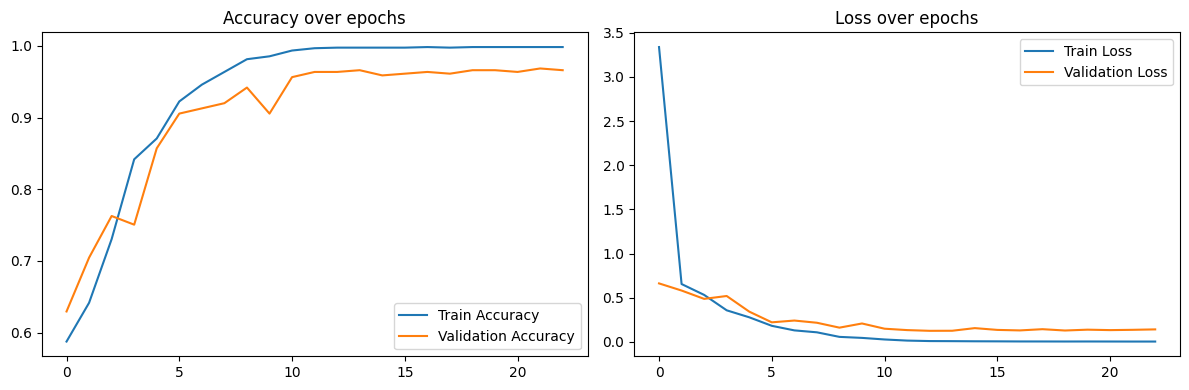

In [49]:
# def main():
#     # Подготовка данных
#     print("Preparing dataset...")
#     # X, y = prepare_dataset(wav_folder)
    
#     all_files = []
#     for root, dirs, files in os.walk(wav_folder):
#         all_files.extend([os.path.join(root, f) for f in files if f.endswith('.wav')])
    
#     train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42, 
#                                              stratify=[1 if "скрипка" in f.lower() else 0 for f in all_files])
    
#     X_train, y_train = prepare_dataset(train_files)
#     X_test, y_test = prepare_dataset(test_files)
    
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
#     # print("Баланс классов:", np.unique(y, return_counts=True))
    
#     # Сохраняем обработанные данные для будущего использования
#     joblib.dump((X, y), os.path.join(output_dir, 'processed_data.joblib'))
    
#     # Разделяем на train/val/test
#     X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
#     X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    
#     print(f"Train shape: {X_train.shape}, {y_train.shape}")
#     print(f"Validation shape: {X_val.shape}, {y_val.shape}")
#     print(f"Test shape: {X_test.shape}, {y_test.shape}")
    
#     # Обучаем модель
#     input_shape = X_train.shape[1:]
#     model, history = train_model(X_train, y_train, X_val, y_val, input_shape)
    
#     # Оценка на тестовых данных
#     test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
#     print(f"\nTest Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")
    
#     # Визуализация обучения
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.title('Accuracy over epochs')
#     plt.legend()
    
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.title('Loss over epochs')
#     plt.legend()
    
#     plt.tight_layout()
#     plt.savefig(os.path.join(output_dir, 'training_history.png'))
#     plt.show()
    
# if __name__ == "__main__":
#     main()

def main():
    # 1. Собираем все файлы и метки
    all_files = []
    labels = []
    for root, dirs, files in os.walk(wav_folder):
        for f in files:
            if f.endswith('.wav'):
                all_files.append(os.path.join(root, f))
                labels.append(1 if "скрипка" in f.lower() else 0)
    
    # 2. Проверяем баланс классов
    unique, counts = np.unique(labels, return_counts=True)
    print("Распределение классов в исходных данных:", dict(zip(unique, counts)))
    
    # 3. Разделяем на train/test (80/20)
    train_files, test_files, y_train_files, y_test_files = train_test_split(
        all_files, labels, 
        test_size=0.2, 
        random_state=42,
        stratify=labels
    )
    
    # 4. Обрабатываем данные
    print("\nОбработка тренировочных данных...")
    X_train, y_train = prepare_dataset(train_files)
    
    print("\nОбработка тестовых данных...")
    X_test, y_test = prepare_dataset(test_files)
    
    # 5. Разделяем train на train/val (75/25)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=0.25,
        random_state=42,
        stratify=y_train
    )
    
    # 6. Сохраняем данные
    os.makedirs(output_dir, exist_ok=True)
    joblib.dump(
        {'X_train': X_train, 'y_train': y_train,
         'X_val': X_val, 'y_val': y_val,
         'X_test': X_test, 'y_test': y_test},
        os.path.join(output_dir, 'processed_data.joblib')
    )
    
    # 7. Выводим информацию о данных
    print("\nФинальные размеры данных:")
    print(f"Train: {X_train.shape} {y_train.shape}")
    print(f"Validation: {X_val.shape} {y_val.shape}")
    print(f"Test: {X_test.shape} {y_test.shape}")
    print("Баланс классов в train:", np.unique(y_train, return_counts=True))
    
    # 8. Обучаем модель
    input_shape = X_train.shape[1:]
    model, history = train_model(X_train, y_train, X_val, y_val, input_shape)
    
    # 9. Оценка модели
    print("\nОценка на тестовых данных:")
    test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")
    
    # 10. Визуализация
    plot_training_history(history)

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    plt.show()
    
if __name__ == "__main__":
    main()    

Теперь проверим на других данных как работает модель

In [51]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import soundfile as sf

def debug_predict(file_path, model, segment_duration=1.0):
    """
    Возвращает:
        - predictions: список вероятностей для всех сегментов,
        - mean_prob: средняя вероятность.
    """
    y, sr = librosa.load(file_path, sr=22050, mono=True)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)  # Обрезка тишины
    segment_samples = int(segment_duration * sr)
    predictions = []
    
    info = sf.info(file_path)
    print(f"Sample rate: {info.samplerate}, Channels: {info.channels}, Duration: {info.duration}s")

    
    for i, start in enumerate(range(0, len(y_trimmed), segment_samples)):
        segment = y_trimmed[start:start+segment_samples]
        if len(segment) < segment_samples:
            continue  # Пропускаем неполные сегменты
            
        # Создание спектрограммы
        spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        
        # Визуализация только первого сегмента
        if i == 0:
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title("Spectrogram (First Segment)")
            plt.show()
            print(f"Max amplitude (first segment): {np.max(np.abs(segment))}")
        
        # Нормализация и предсказание
        spectrogram_norm = (spectrogram_db - spectrogram_db.min()) / (spectrogram_db.max() - spectrogram_db.min())
        input_data = spectrogram_norm[np.newaxis, ..., np.newaxis]
        pred = model.predict(input_data, verbose=0)[0][0]
        predictions.append(pred)
    
    return predictions, np.mean(predictions)

# Пример использования
file_path = 'lettersabc/a/balanced_instruments/wav/muse_score/Celesta_no_pauses.wav'
model = load_model('best_model.h5')
predictions, avg_pred = debug_predict(file_path, model)

# Вывод результатов
print(f"Предсказания для сегментов: {predictions}")
print(f"Средняя вероятность: {avg_pred:.4f}")
print(f"Итоговый класс: {'violin' if avg_pred > 0.5 else 'other'}")

C:\Users\E8904\AppData\Local\Temp\ipykernel_16260\1483256374.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050, mono=True)


FileNotFoundError: [Errno 2] No such file or directory: 'lettersabc/a/balanced_instruments/wav/muse_score/Celesta_no_pauses.wav'

Модель успешно загружена

Информация о файле:
Формат: стерео
Частота: 48000 Hz
Длительность: 119.93 сек

Обработка файла...


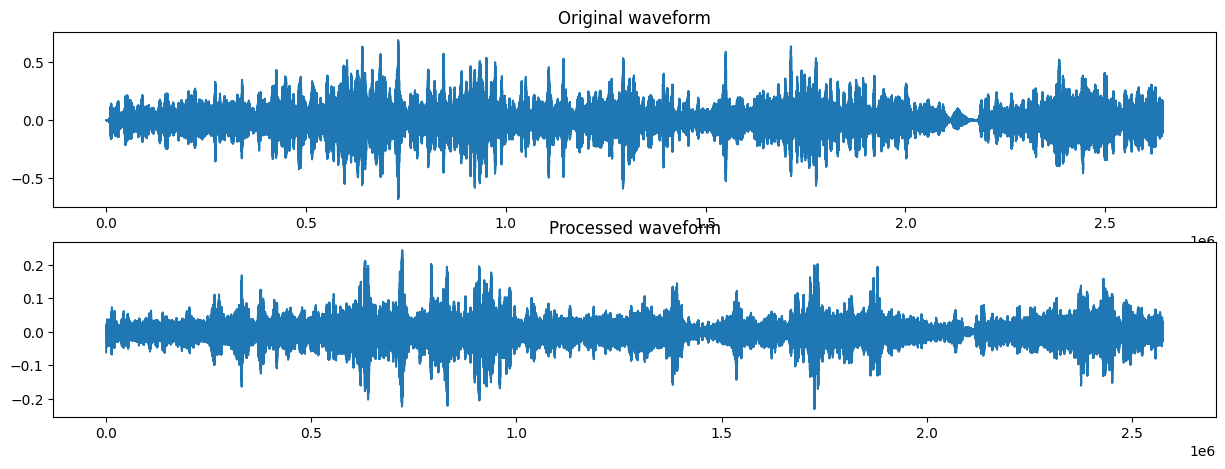

Длина после загрузки: 119.93 сек
Длина после обрезки: 116.84 сек
Длина после обработки: 116.82 сек
Сегмент 0: длина 3.00 сек (требуется 1.50 сек)


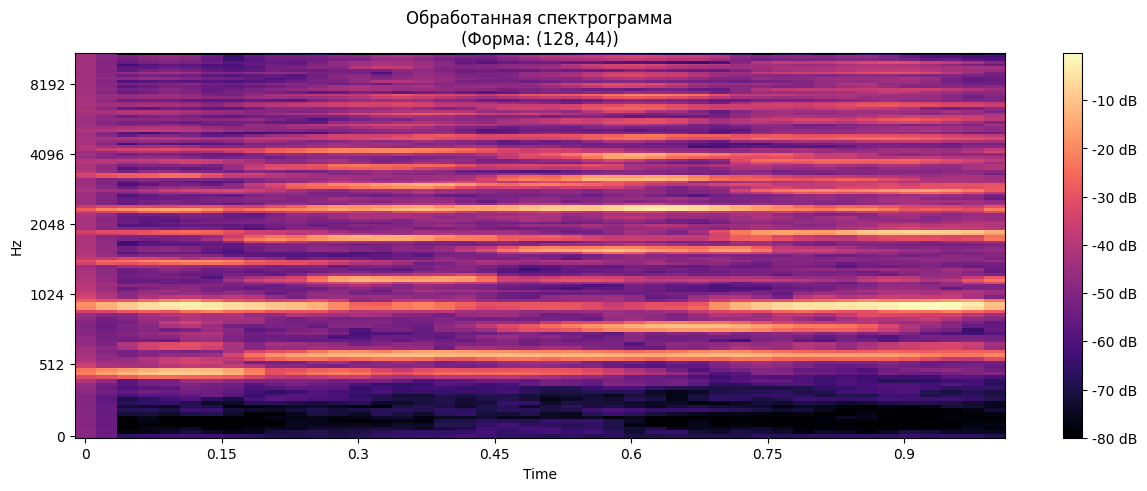


Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -0.14519882 Mean: -46.03912


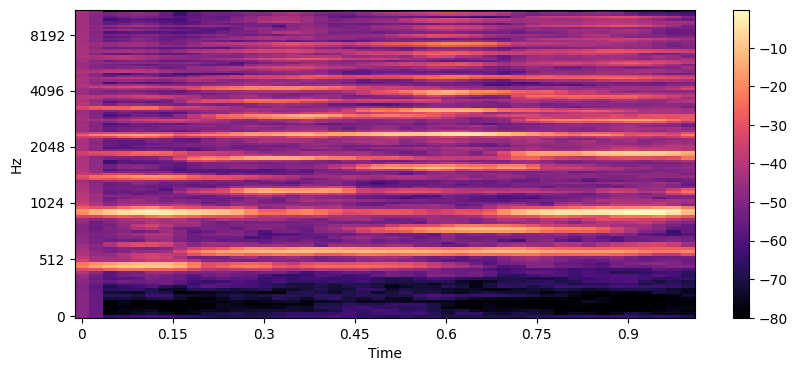

Сегмент 0: p=0.1559
Сегмент 0: p=0.1559 (сомнительный)
Сегмент 1: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -3.339662 Mean: -40.680885


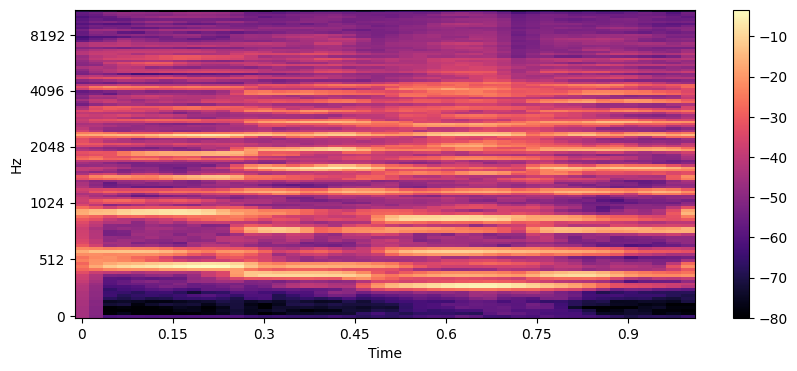

Сегмент 1: p=0.1507
Сегмент 1: p=0.1507 (сомнительный)
Сегмент 2: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -0.32013607 Mean: -43.066696


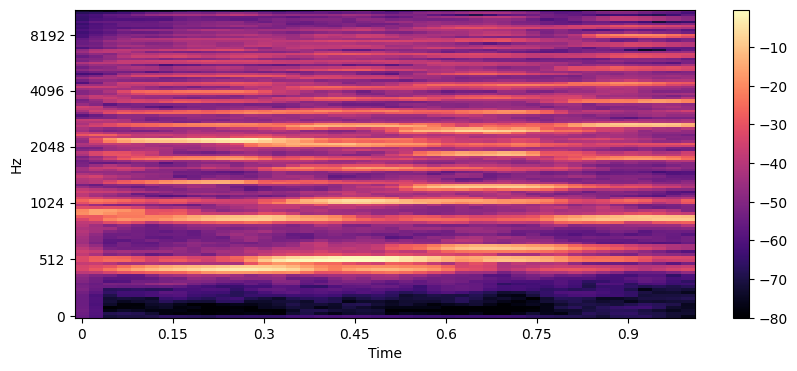

Сегмент 2: p=0.1448
Сегмент 2: p=0.1448 (сомнительный)
Сегмент 3: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -8.477717 Mean: -49.676964


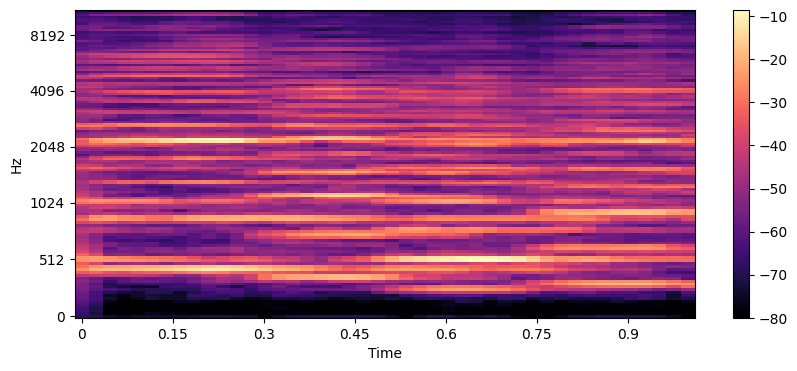

Сегмент 3: p=0.1414
Сегмент 3: p=0.1414 (сомнительный)
Сегмент 4: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -5.032551 Mean: -49.517246


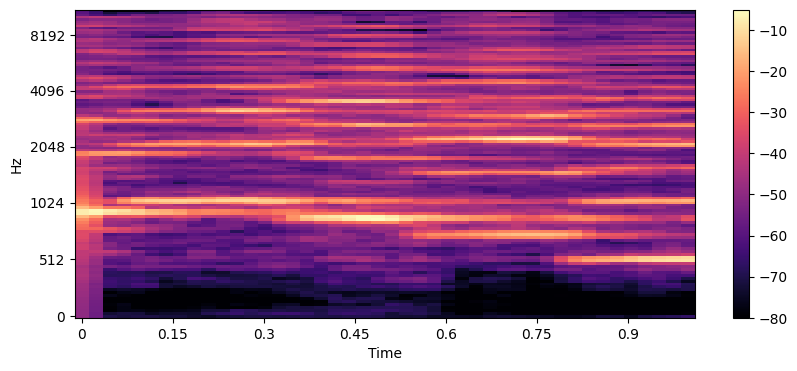

Сегмент 4: p=0.1523
Сегмент 4: p=0.1523 (сомнительный)
Сегмент 5: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: 0.0 Mean: -45.50677


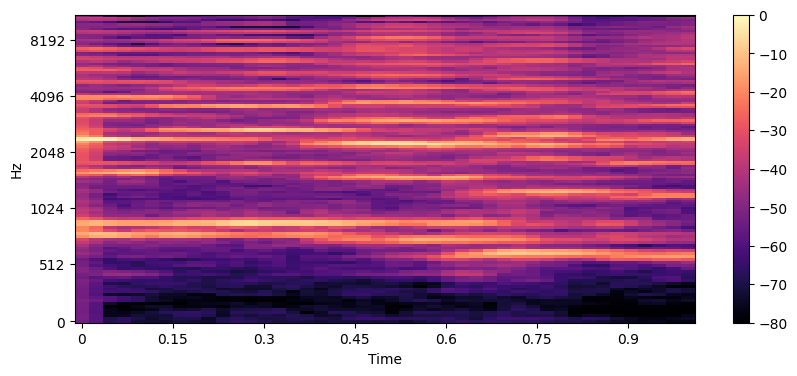

Сегмент 5: p=0.1481
Сегмент 5: p=0.1481 (сомнительный)
Сегмент 6: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -1.0660868 Mean: -43.9354


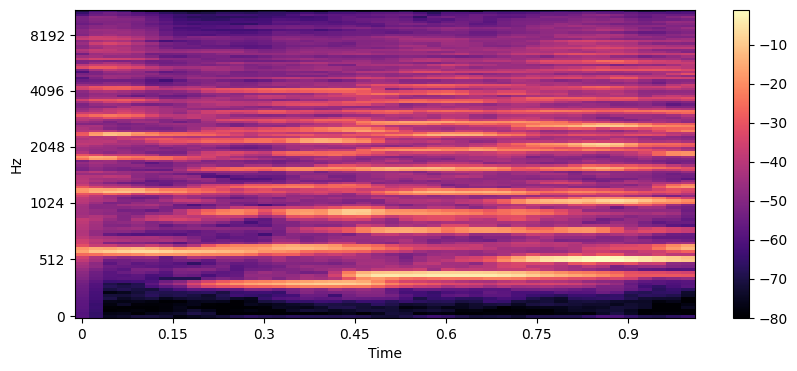

Сегмент 6: p=0.1855
Сегмент 6: p=0.1855 (сомнительный)
Сегмент 7: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -0.35921 Mean: -43.256313


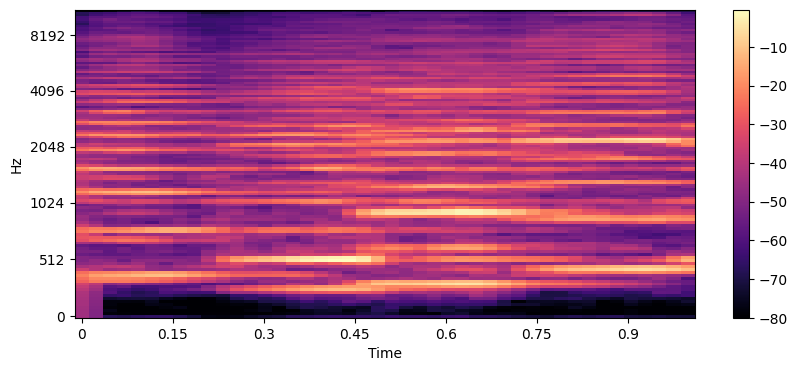

Сегмент 7: p=0.1495
Сегмент 7: p=0.1495 (сомнительный)
Сегмент 8: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -1.1395273 Mean: -44.464146


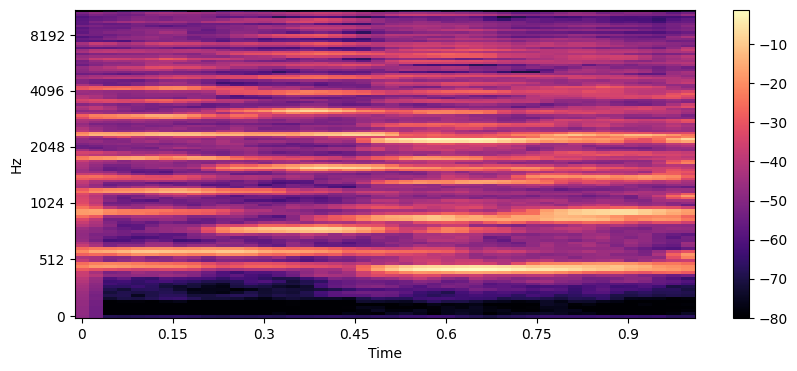

Сегмент 8: p=0.1379
Сегмент 8: p=0.1379 (сомнительный)
Сегмент 9: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -7.3289165 Mean: -46.694992


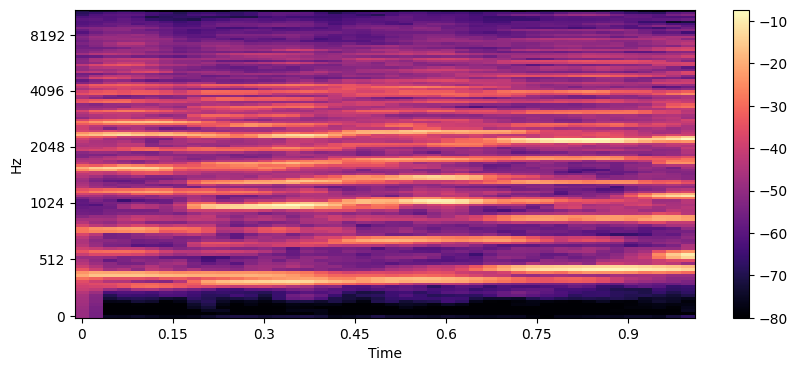

Сегмент 9: p=0.1571
Сегмент 9: p=0.1571 (сомнительный)
Сегмент 10: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -11.27895 Mean: -49.412655


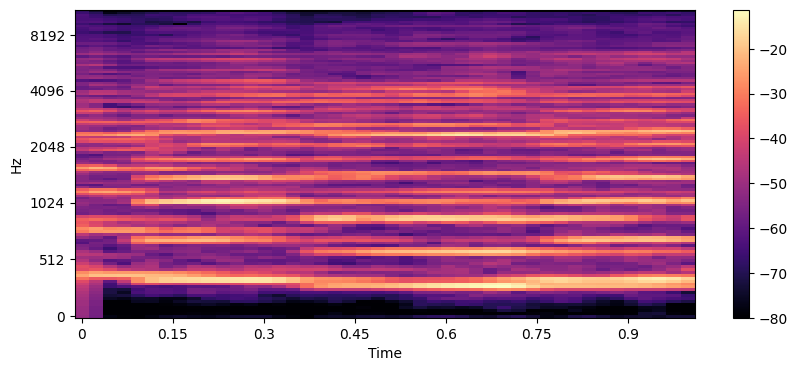

Сегмент 10: p=0.1525
Сегмент 10: p=0.1525 (сомнительный)
Сегмент 11: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -8.9418335 Mean: -50.563866


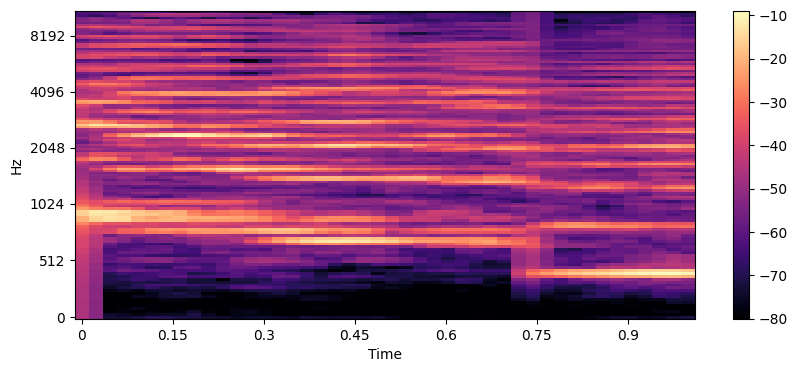

Сегмент 11: p=0.1454
Сегмент 11: p=0.1454 (сомнительный)
Сегмент 12: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -1.4662132 Mean: -47.201317


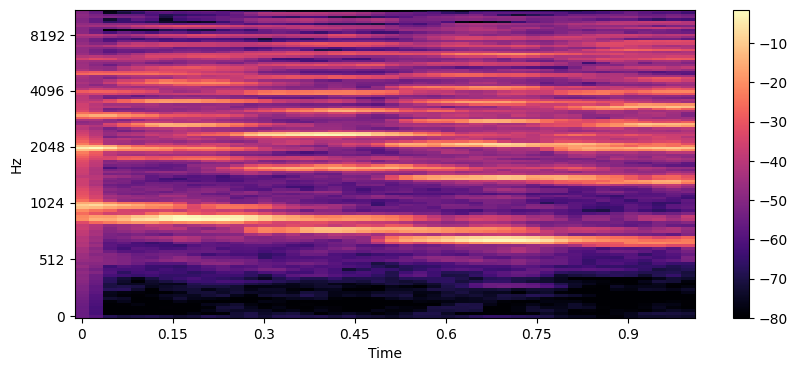

Сегмент 12: p=0.1416
Сегмент 12: p=0.1416 (сомнительный)
Сегмент 13: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -13.100948 Mean: -51.456974


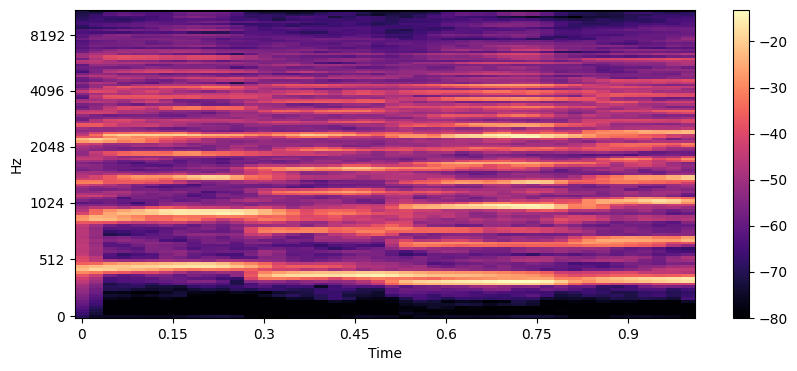

Сегмент 13: p=0.1689
Сегмент 13: p=0.1689 (сомнительный)
Сегмент 14: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: 0.0 Mean: -46.564377


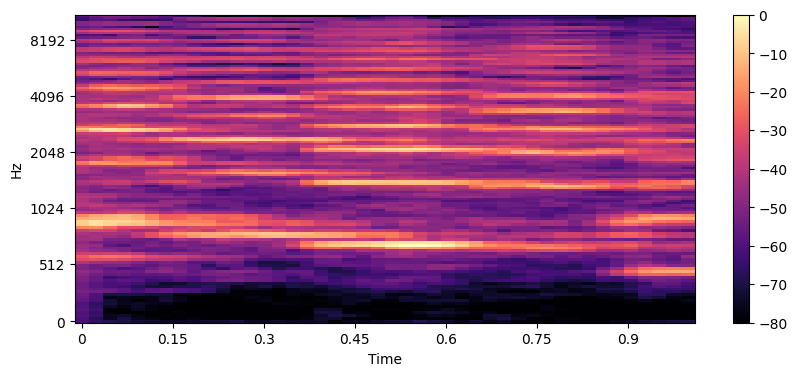

Сегмент 14: p=0.1565
Сегмент 14: p=0.1565 (сомнительный)
Сегмент 15: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -5.7370787 Mean: -48.281418


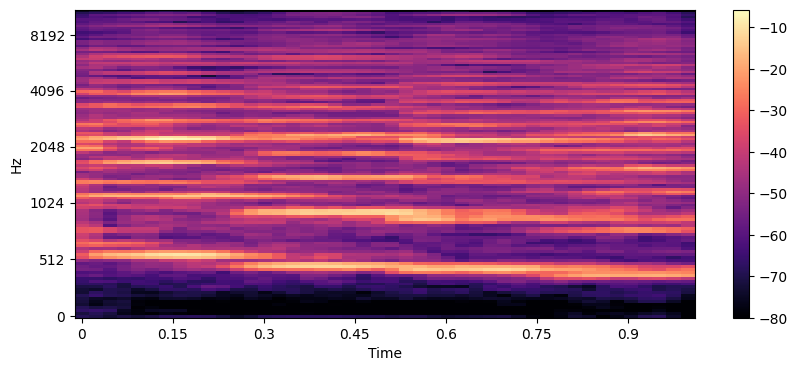

Сегмент 15: p=0.1637
Сегмент 15: p=0.1637 (сомнительный)
Сегмент 16: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -3.238153 Mean: -44.94285


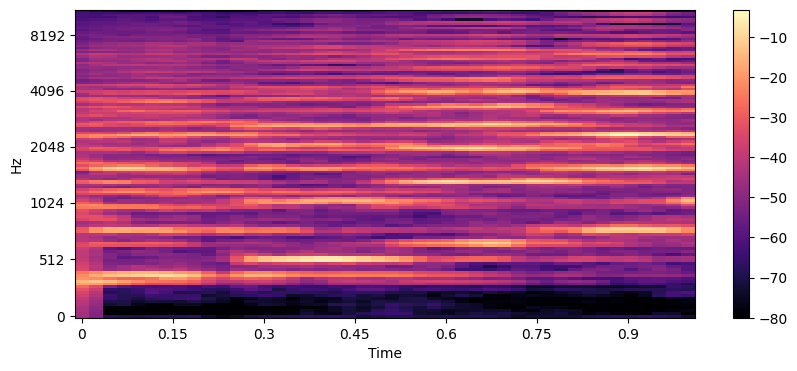

Сегмент 16: p=0.1548
Сегмент 16: p=0.1548 (сомнительный)
Сегмент 17: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: 0.0 Mean: -45.13074


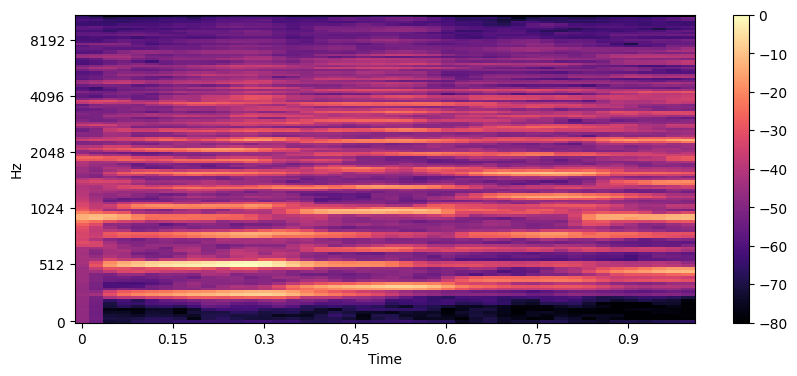

Сегмент 17: p=0.1604
Сегмент 17: p=0.1604 (сомнительный)
Сегмент 18: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: 0.0 Mean: -44.216724


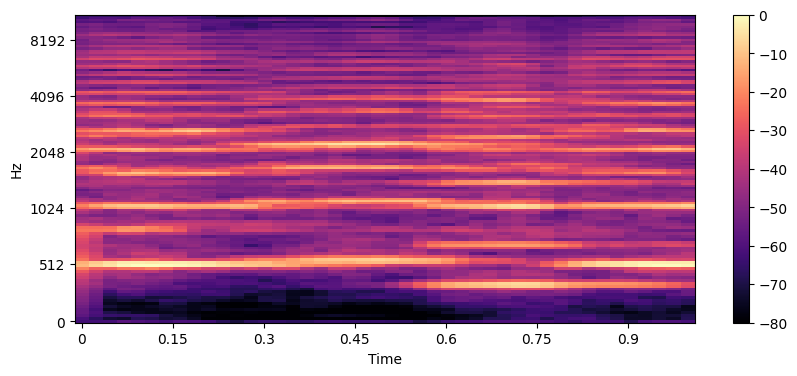

Сегмент 18: p=0.1710
Сегмент 18: p=0.1710 (сомнительный)
Сегмент 19: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -0.8072424 Mean: -44.794033


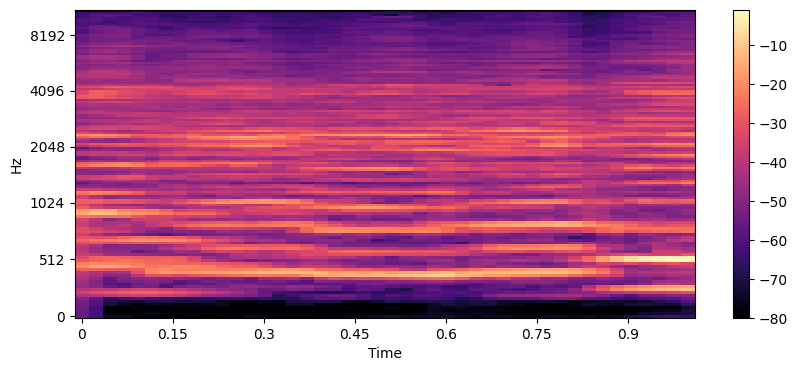

Сегмент 19: p=0.1649
Сегмент 19: p=0.1649 (сомнительный)
Сегмент 20: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -6.9125395 Mean: -50.905655


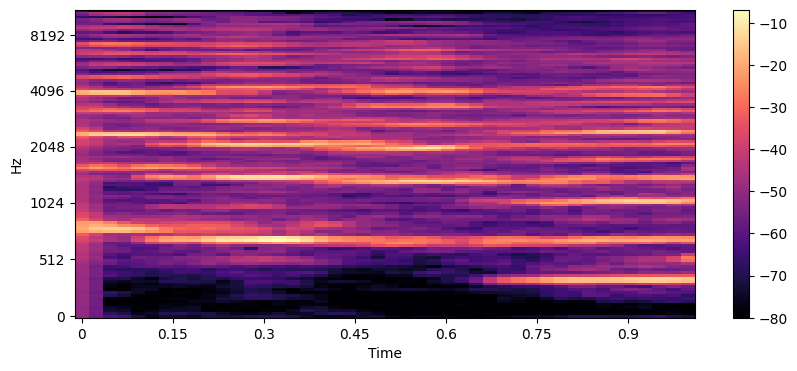

Сегмент 20: p=0.1819
Сегмент 20: p=0.1819 (сомнительный)
Сегмент 21: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: 0.0 Mean: -50.107517


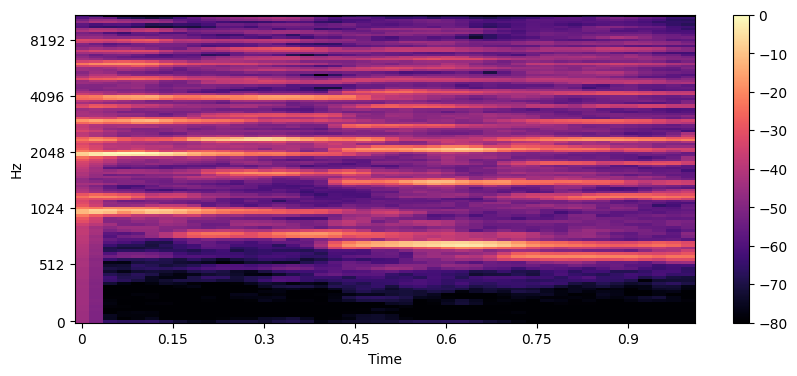

Сегмент 21: p=0.1649
Сегмент 21: p=0.1649 (сомнительный)
Сегмент 22: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -4.0961323 Mean: -44.0137


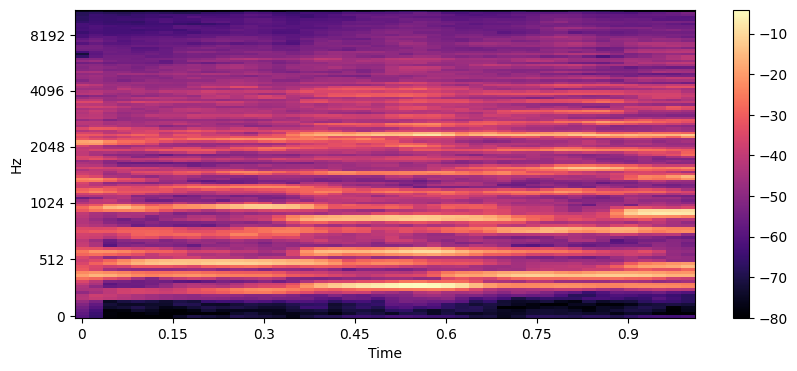

Сегмент 22: p=0.1647
Сегмент 22: p=0.1647 (сомнительный)
Сегмент 23: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: 0.0 Mean: -49.373535


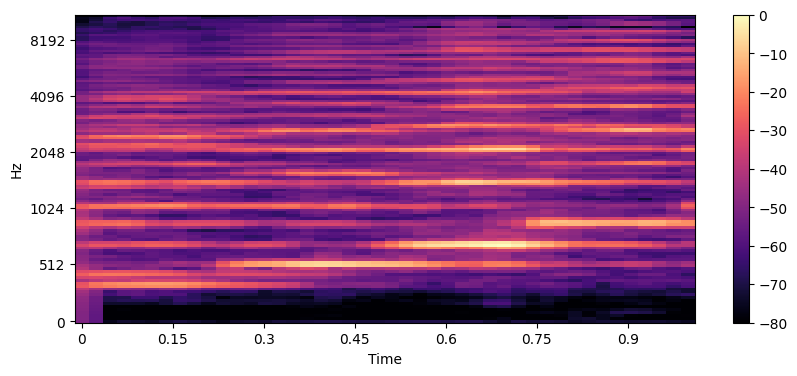

Сегмент 23: p=0.1650
Сегмент 23: p=0.1650 (сомнительный)
Сегмент 24: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -2.392438 Mean: -45.19377


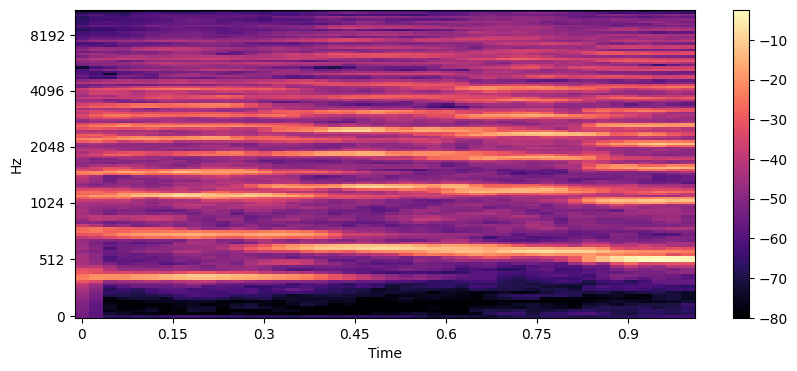

Сегмент 24: p=0.1739
Сегмент 24: p=0.1739 (сомнительный)
Сегмент 25: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -7.0119534 Mean: -50.000248


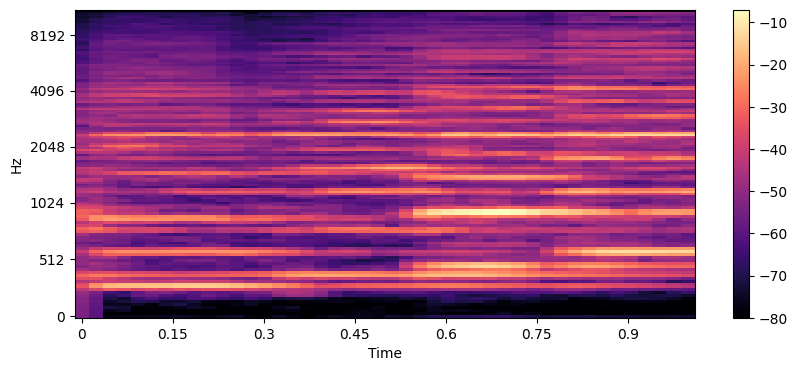

Сегмент 25: p=0.1642
Сегмент 25: p=0.1642 (сомнительный)
Сегмент 26: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -1.9073486e-06 Mean: -48.04674


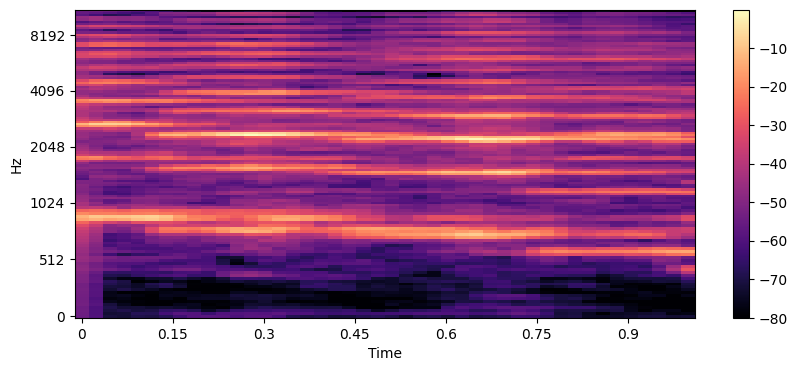

Сегмент 26: p=0.1400
Сегмент 26: p=0.1400 (сомнительный)
Сегмент 27: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -1.8939743 Mean: -47.048218


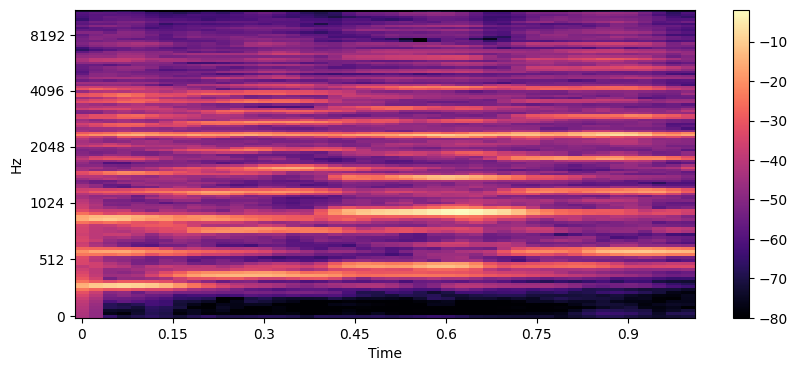

Сегмент 27: p=0.1527
Сегмент 27: p=0.1527 (сомнительный)
Сегмент 28: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -1.2658062 Mean: -50.041447


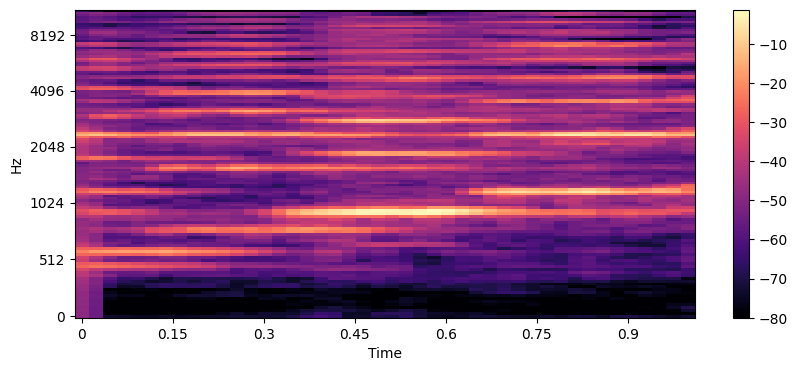

Сегмент 28: p=0.1625
Сегмент 28: p=0.1625 (сомнительный)
Сегмент 29: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: 0.0 Mean: -42.398106


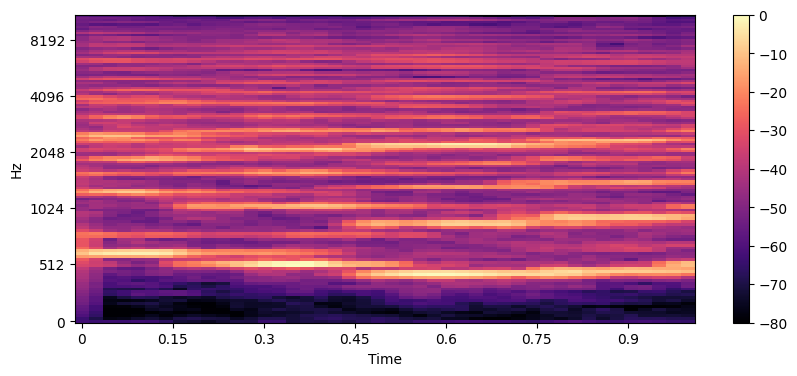

Сегмент 29: p=0.1517
Сегмент 29: p=0.1517 (сомнительный)
Сегмент 30: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: 0.0 Mean: -41.008926


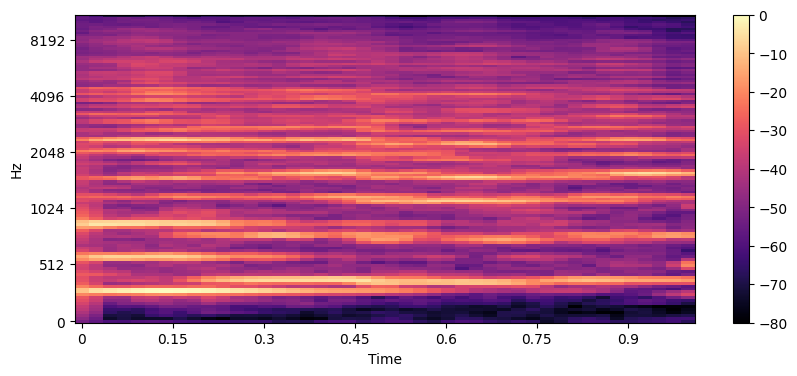

Сегмент 30: p=0.1508
Сегмент 30: p=0.1508 (сомнительный)
Сегмент 31: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: 0.0 Mean: -43.97003


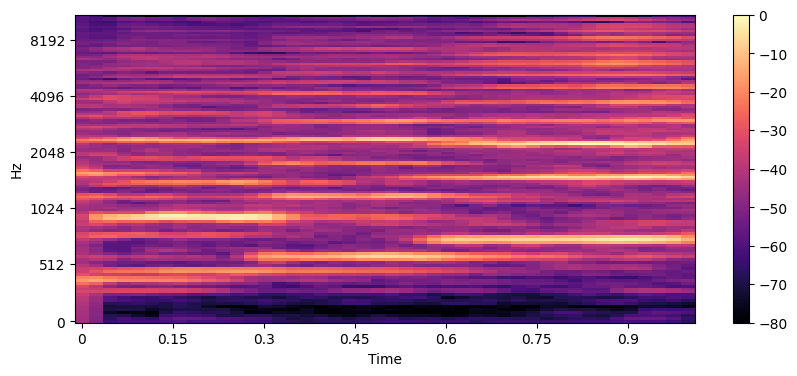

Сегмент 31: p=0.1478
Сегмент 31: p=0.1478 (сомнительный)
Сегмент 32: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -0.2944851 Mean: -50.333023


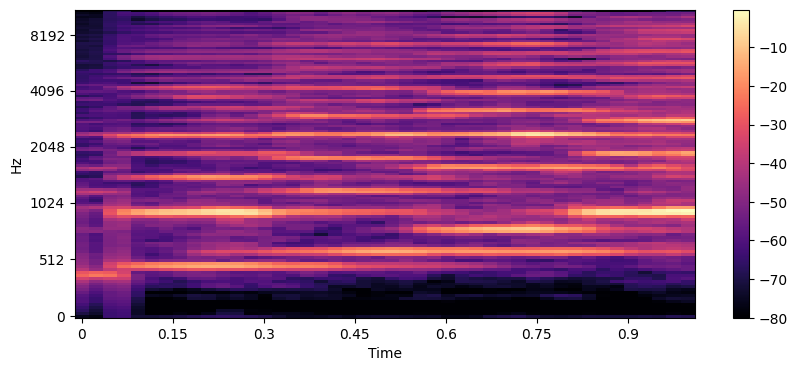

Сегмент 32: p=0.1574
Сегмент 32: p=0.1574 (сомнительный)
Сегмент 33: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -5.162283 Mean: -44.250656


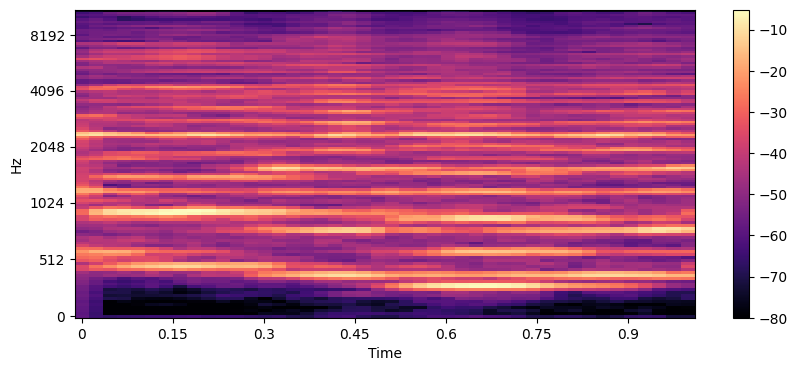

Сегмент 33: p=0.1592
Сегмент 33: p=0.1592 (сомнительный)
Сегмент 34: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -1.7357149 Mean: -46.124256


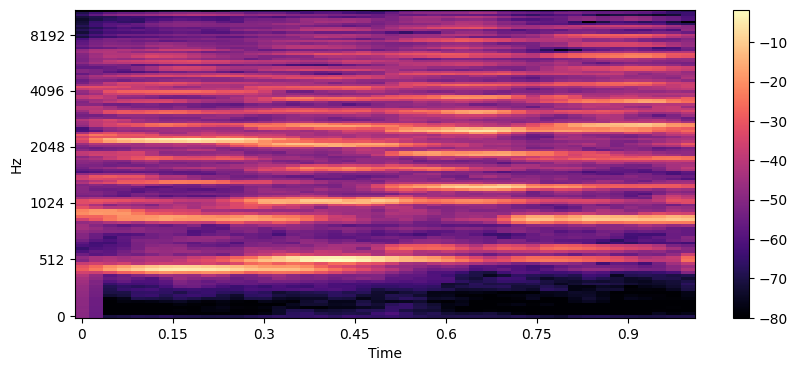

Сегмент 34: p=0.1551
Сегмент 34: p=0.1551 (сомнительный)
Сегмент 35: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -4.4263144 Mean: -46.997204


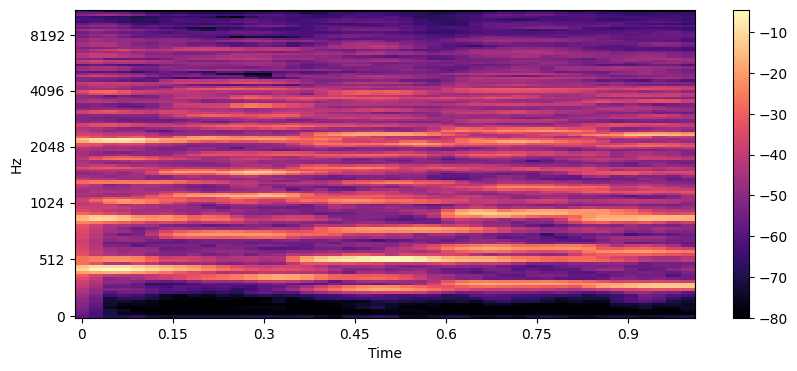

Сегмент 35: p=0.1570
Сегмент 35: p=0.1570 (сомнительный)
Сегмент 36: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -3.1331835 Mean: -48.18291


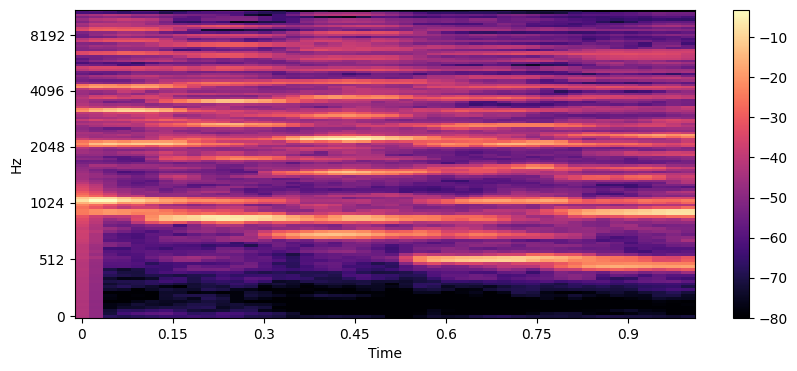

Сегмент 36: p=0.1420
Сегмент 36: p=0.1420 (сомнительный)
Сегмент 37: длина 3.00 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: 0.0 Mean: -47.337414


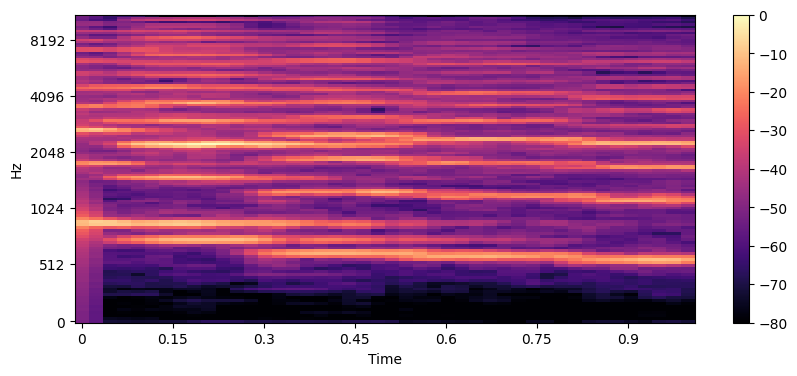

Сегмент 37: p=0.1691
Сегмент 37: p=0.1691 (сомнительный)
Сегмент 38: длина 2.82 сек (требуется 1.50 сек)

Проверка спектрограммы для whispered-dreams-20240601-041419.wav:
Min: -80.0 Max: -0.119626045 Mean: -40.717472


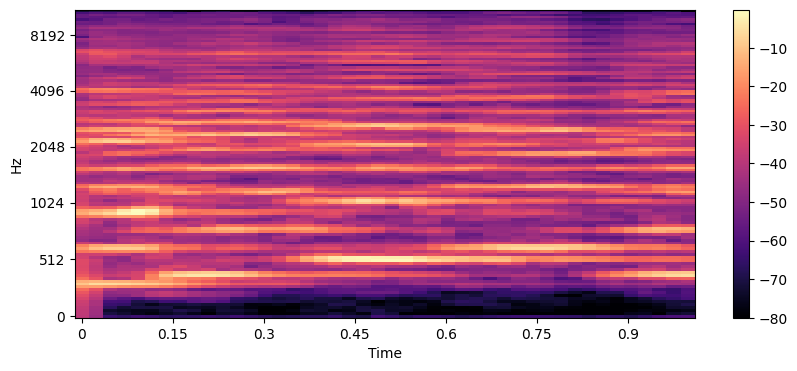

Сегмент 38: p=0.1556
Сегмент 38: p=0.1556 (сомнительный)

Результаты:
Всего сегментов: 39
Средняя вероятность: 0.1569
Итоговый класс: other


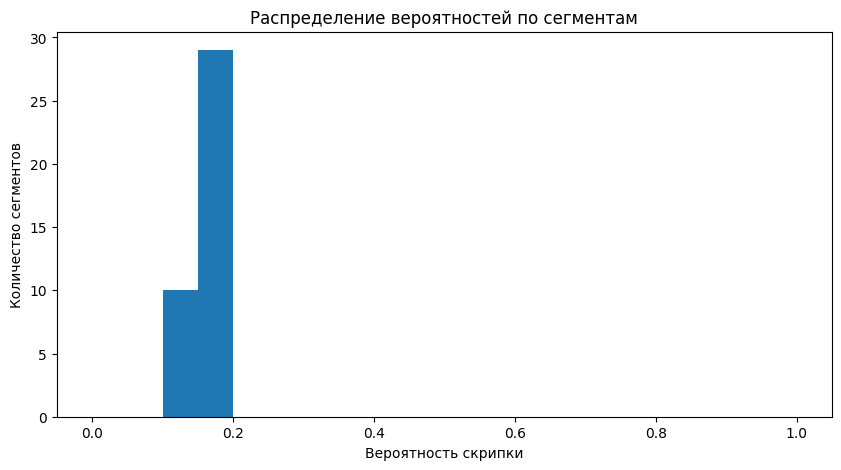

In [52]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import soundfile as sf

def debug_predict(file_path, model, segment_duration=3.0, target_time_steps=44):
    # Загрузка аудио
    y, sr = librosa.load(file_path, sr=22050, mono=True)
    
    y_trimmed = librosa.effects.split(y, top_db=25, frame_length=2048, hop_length=512)  # Делим на ненулевые участки
    y_trimmed = np.concatenate([y[start:end] for (start, end) in y_trimmed])
    
    # Альтернативное шумоподавление (если noisereduce не работает)
    # 1. Обрезка тишины
    # y_trimmed, _ = librosa.effects.trim(y, top_db=30)
    
    # 2. Медианный фильтр для подавления шумов
    y_clean = librosa.effects.preemphasis(y_trimmed, coef=0.97)
    
    # 3. Спектральное шумоподавление
    S = librosa.stft(y_clean)
    S_mag = np.abs(S)
    mask = librosa.util.softmask(S_mag, 0.2 * S_mag, power=2)
    S_clean = S * mask
    y_processed = librosa.istft(S_clean)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(2, 1, 1)
    plt.plot(y)
    plt.title("Original waveform")
    plt.subplot(2, 1, 2)
    plt.plot(y_processed)
    plt.title("Processed waveform")
    plt.show()
    
    print(f"Длина после загрузки: {len(y)/sr:.2f} сек")
    print(f"Длина после обрезки: {len(y_trimmed)/sr:.2f} сек")
    print(f"Длина после обработки: {len(y_processed)/sr:.2f} сек")
    
    # Остальной код остается без изменений...
    segment_samples = int(segment_duration * sr)
    predictions = []
    
    for i, start in enumerate(range(0, len(y_processed), segment_samples)):
        segment = y_processed[start:start+segment_samples]
        print(f"Сегмент {i}: длина {len(segment)/sr:.2f} сек (требуется {segment_duration/2:.2f} сек)")
        if len(segment) < segment_samples//2:
            print("Пропуск сегмента - слишком короткий")
            continue
            
        hop_length = max(1, len(segment) // (target_time_steps - 1))
        S = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128,
                                         hop_length=512, n_fft=2048)
        S_db = librosa.power_to_db(S, ref=np.max)
        
        if S_db.shape[1] != target_time_steps:
            S_db = librosa.util.fix_length(S_db, size=target_time_steps, axis=1)
        
        if i == 0:
            plt.figure(figsize=(15, 5))
            librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"Обработанная спектрограмма\n(Форма: {S_db.shape})")
            plt.show()
        
        # После создания спектрограммы
        print(f"\nПроверка спектрограммы для {file_path}:")
        print("Min:", S_db.min(), "Max:", S_db.max(), "Mean:", S_db.mean())
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar()
        plt.show()
        
        S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-10)
        input_data = S_norm[np.newaxis, ..., np.newaxis]
        
        pred = model.predict(input_data, verbose=0)[0][0]
        predictions.append(pred)
        
        print(f"Сегмент {i}: p={pred:.4f}")
        
        if 0.1 < pred < 0.9:
            print(f"Сегмент {i}: p={pred:.4f} (сомнительный)")
        elif pred >= 0.9:
            print(f"Сегмент {i}: p={pred:.4f} (явная скрипка)")
            
        # if pred > 0.7 or pred < 0.3:  # Подозрительные сегменты
        #     plot_segment(segment, sr, f"Сегмент {i}: p={pred:.4f}")
    
    avg_pred = np.mean(predictions) if predictions else 0.0
    return predictions, avg_pred

# def plot_segment(y_segment, sr, title):
#     S = librosa.feature.melspectrogram(y=y_segment, sr=sr)
#     S_db = librosa.power_to_db(S, ref=np.max)
    
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title(title)
    
#     plt.subplot(1, 2, 2)
#     plt.plot(y_segment)
#     plt.title("Waveform")
#     plt.tight_layout()
#     plt.show()

# Пример использования
if __name__ == "__main__":
    # file_path = 'lettersabc/a/balanced_instruments/wav/muse_score/Скрипка_1.wav'
    # file_path = 'lettersabc/a/balanced_instruments/wav/muse_score/Банджо_1.wav'
    file_path = 'whispered-dreams-20240601-041419.wav'
    # file_path = 'Violin_for_test1.wav'
    # file_path = 'krasivaya-i-krasivaya-fortepiannaya-muzyika-40481.wav'
    
    try:
        model = load_model('best_model.h5')
        print("Модель успешно загружена")
        
        # Проверка файла
        info = sf.info(file_path)
        print(f"\nИнформация о файле:")
        print(f"Формат: {'стерео' if info.channels > 1 else 'моно'}")
        print(f"Частота: {info.samplerate} Hz")
        print(f"Длительность: {info.duration:.2f} сек")
        
        print("\nОбработка файла...")
        predictions, avg_pred = debug_predict(file_path, model)
        
        print("\nРезультаты:")
        print(f"Всего сегментов: {len(predictions)}")
        print(f"Средняя вероятность: {avg_pred:.4f}")
        print(f"Итоговый класс: {'violin' if avg_pred > 0.5 else 'other'}")
        
        # Визуализация распределения вероятностей
        plt.figure(figsize=(10, 5))
        plt.hist(predictions, bins=20, range=(0, 1))
        plt.title("Распределение вероятностей по сегментам")
        plt.xlabel("Вероятность скрипки")
        plt.ylabel("Количество сегментов")
        plt.show()
        
    except Exception as e:
        print(f"Ошибка: {str(e)}")